In [1]:
import random
import torch
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from datetime import datetime
import os
import time

%load_ext autoreload
%autoreload 2

In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from dpk.koopman_probabilistic import KoopmanProb
from dpk.model_objs import NormalNLL

[ Using Seed :  633  ]


In [3]:
# choose a station
station_name = "EEA_FR_FR04131"
station_fname = f"model_analysis_{station_name}.csv"  # "obs_{station_name}.csv"

In [4]:
station_path = "./HighNO2/"

In [5]:
start_date = np.datetime64("2018-01-16")  # sometimes there's data from before jan 1 2018, let's ignore that
if station_fname.startswith("obs"):
    obsfile = os.path.join(station_path, station_fname)
    obs = pd.read_csv(obsfile, parse_dates=['ISO8601',], date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601'])
    obs = obs[obs.ISO8601 >= start_date]
    obs["t"] = [time.mktime(obs.ISO8601.iloc[i].timetuple()) for i in range(len(obs))]
    t_min = obs.t.min()
    obs.t -= t_min
    obs_no2 = obs.loc[obs.obstype=='no2']
 
    obs_no2

In [6]:
start_date = np.datetime64("2018-01-16")
if station_fname.startswith("model_analysis"):
    modfile = os.path.join(station_path, station_fname)
    mod = pd.read_csv(modfile, parse_dates=['ISO8601',], date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601'])
    mod.ISO8601 -= dt.timedelta(minutes=30)  # the timestamps in mod were misaligned
    mod = mod[mod.ISO8601 >= start_date]
    mod["t"] = [time.mktime(mod.ISO8601.iloc[i].timetuple()) for i in range(len(mod))]
    t_min = mod.t.min()
    mod.t -= t_min

    mod

In [8]:
if station_fname.startswith("obs"):
    plt.plot(obs.t, np.ones(len(obs.t)), ".")  # make sure there are no huge gaps in the data

x (34704, 1)
t (34704,)
[]
x (34704, 1)
t (34704,)


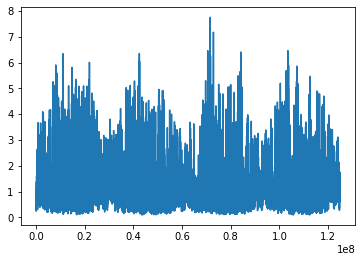

In [9]:
# set up the time-series for prediction
chemical = "NO2"
if station_fname.startswith("obs"):
    x = np.expand_dims(obs_no2.conc_obs.values, -1)
    t = obs_no2.t.values
else:
    x = np.expand_dims(mod.no2.values, -1)
    t = mod.t.values
print("x", x.shape)
print("t", t.shape)
null_idx = np.isnan(x).nonzero()[0]
print(null_idx)
x[null_idx] = (x[null_idx - 1] + x[null_idx + 1]) / 2
if x.min() <= 0:
    print("nonpositive observed concentration: ", x[x<=0])
    x[x <= 0] = 1e-20
x_original = x
scale = np.std(x, axis=0)
x = x / np.tile(scale, (x.shape[0], 1))
print("x", x.shape)
print("t", t.shape)
plt.figure()
plt.plot(t, x)

x (20424, 1)
x_train (17544, 1)


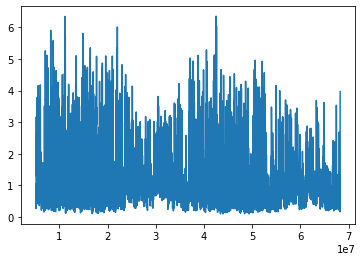

In [10]:
# split time-series
train_start_date = np.datetime64("2018-03-16")
train_end_date = np.datetime64("2020-03-16")  # covid start date
covid_end_date = np.datetime64("2020-05-16")
if station_fname.startswith("obs"):
    train_start = np.argwhere(obs_no2.ISO8601.values >= train_start_date)[0, 0]
    train_end = np.argwhere(obs_no2.ISO8601.values <= train_end_date)[-1, 0]
    covid_end = np.argwhere(obs_no2.ISO8601.values <= covid_end_date)[-1, 0]
else:
    train_start = np.argwhere(mod.ISO8601.values >= train_start_date)[0, 0]
    train_end = np.argwhere(mod.ISO8601.values <= train_end_date)[-1, 0]
    covid_end = np.argwhere(mod.ISO8601.values <= covid_end_date)[-1, 0]
data_name = chemical + station_name

x = x[:covid_end]
t = t[:covid_end]

delay = 0

x_train = x[train_start:train_end]
t_train = t[train_start:train_end]

now = ("_".join(str(datetime.now()).split())).replace(":", ".")
print("x", x.shape)
print("x_train", x_train.shape)
plt.figure()
plt.plot(t_train, x_train)
plt.show()

In [11]:
train_start, train_end, covid_end

(1416, 18960, 20424)

In [12]:
# model hyperparameters
periods = 60 * 60 * np.array([24, 24 * 7, 24 * 365.24], dtype=np.float64)  # seconds
l1width = 256
l2width = 1024
wd = 1e-3
lrt = 1e-4
batch_size = 32
model = NormalNLL(x_dim=1, num_freqs=3, n=l1width, n2=l2width, num_covariates=1)  # The covariate is time

# load a pre-trained DPK model
total_iters = 100  # this indicates how long the pre-trained DPK model was trained
# param_str = f"NormalNLL_{station_fname[:-4]}_{l1width}_{l2width}_{batch_size}_{total_iters}_{seed}_{wd}_{lrt}"  # you must still run 1 iteration of training on this model just to initialize the koop
param_str = f"NormalNLL_default_{l1width}_{l2width}"  # use this pre-trained model to initialize a new model to be trained
model.load_state_dict(torch.load(f"forecasts/model_{param_str}.pt"))

koop = KoopmanProb(model, batch_size=batch_size, device="cpu")  # this koop object does the training and prediction for you
koop.init_periods(periods)
total_iters = 0

In [54]:
f"forecasts/model_{param_str}.pt"

'forecasts/model_NormalNLL_model_analysis_EEA_FR_FR04131_256_1024_32_1_633_0.001_0.0001.pt'

In [13]:
iters = 100  # you must run at least 1 iteration in order for the time covariate to be scaled correctly
total_iters += iters
koop.fit(x_train, t_train, covariates=t_train.reshape(len(t_train), 1), iterations=iters, cutoff=0, weight_decay=wd, lr_theta=lrt, lr_omega=0, verbose=True)

Iteration  0
tensor([   86400.0000,   604800.0625, 31556736.0000,    86400.0000,
          604800.0625, 31556736.0000])
Setting periods to tensor([   86400.0000,   604800.0625, 31556736.0000,    86400.0000,
          604800.0625, 31556736.0000], grad_fn=<MulBackward0>)
Loss:  0.10120464
Final loss: 0.10120464


[0.10120464]

In [14]:
# predict the mean and standard deviation
params = koop.predict(t, covariates=t.reshape(len(t), 1))
mu_hat, sigma_hat = params
mean_hat = model.mean(params)
std_hat = model.std(params)

In [15]:
param_str = f"NormalNLL_{station_fname[:-4]}_{l1width}_{l2width}_{batch_size}_{total_iters}_{seed}_{wd}_{lrt}"
np.save(f"forecasts/params_{param_str}.npy", np.array(params))
torch.save(model.state_dict(), f"forecasts/model_{param_str}.pt")

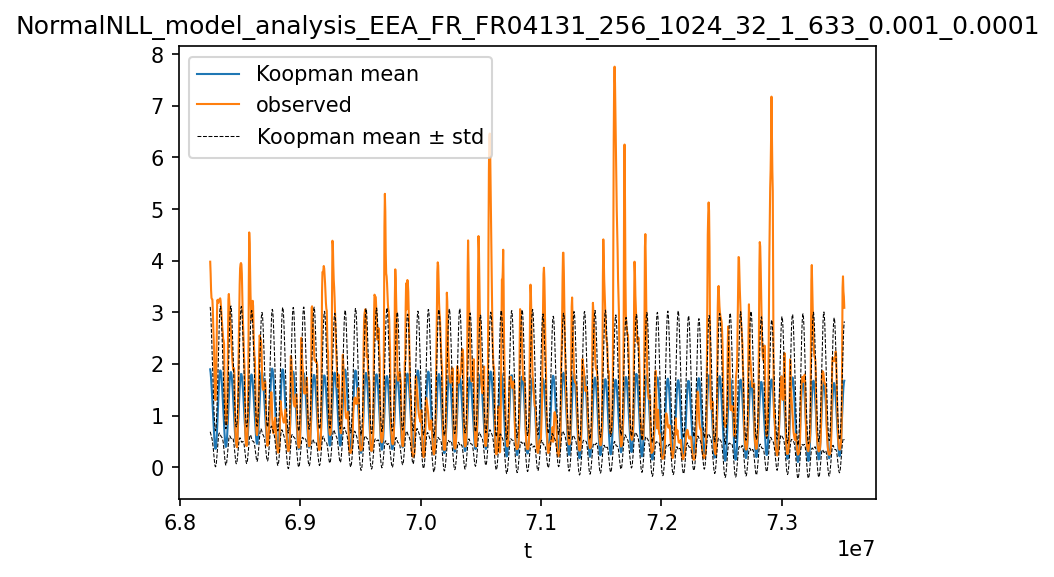

In [16]:
mean_hat = model.mean(params)
std_hat = model.std(params)
plt.figure(dpi=150)
plt.plot(t[train_end:], mean_hat[train_end:, 0], label="Koopman mean", linewidth=1)
plt.plot(t[train_end:], x[train_end:, 0], label="observed", linewidth=1)
plt.plot(t[train_end:], mean_hat[train_end:, 0] + std_hat[train_end:, 0], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
plt.plot(t[train_end:], mean_hat[train_end:, 0] - std_hat[train_end:, 0], "--", color="black", linewidth=0.5)

plt.title(f"{param_str}")
plt.xlabel("t")
# plt.xlim([7e7, 7.1e7])
plt.legend()
plt.show()

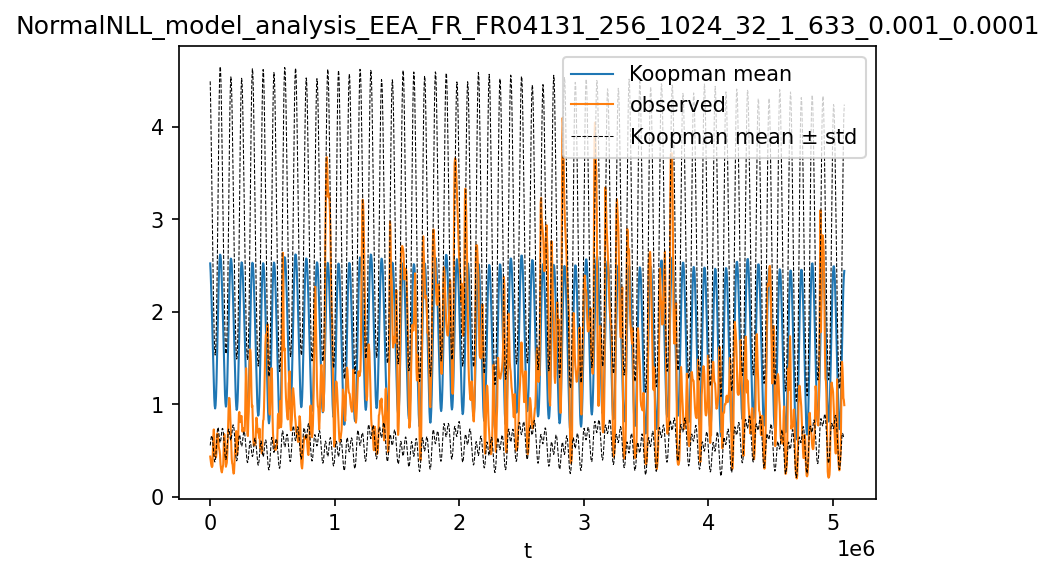

In [17]:
mean_hat = model.mean(params)
std_hat = model.std(params)
plt.figure(dpi=150)
plt.plot(t[:train_start], mean_hat[:train_start, 0], label="Koopman mean", linewidth=1)
plt.plot(t[:train_start], x[:train_start, 0], label="observed", linewidth=1)
plt.plot(t[:train_start], mean_hat[:train_start, 0] + std_hat[:train_start, 0], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
plt.plot(t[:train_start], mean_hat[:train_start, 0] - std_hat[:train_start, 0], "--", color="black", linewidth=0.5)
# plt.xlim([6e6,1.3e7])
plt.title(f"{param_str}")
plt.xlabel("t")
plt.legend()
plt.show()

In [18]:
len(x), len(mean_hat), len(std_hat)

(20424, 20424, 20424)

In [19]:
# find the sampling distribution of consecutive k-averages (k_average = average z-score of k consecutive observations)
k = 24 * 7
z_scores = (x - mean_hat) / std_hat
k_averages = []
k_mses = []
k_samples = np.zeros((covid_end - k + 1, k))

for i in range(0, covid_end - k + 1):
    sample = z_scores[i:i+k]
    k_averages.append(np.mean(sample))
    k_mses.append(np.mean(sample**2))
    k_samples[i, :] = sample.flatten()

train_z_scores = z_scores[train_start:train_end - k + 1]

In [20]:
alpha = 0.001
train_k_averages = k_averages[train_start:train_end - k + 1]
covid_k_averages = k_averages[train_end:]
control_k_averages = k_averages[:train_start - k + 1]
critical_z_bar = sorted(train_k_averages)[int(len(train_k_averages) * alpha)]

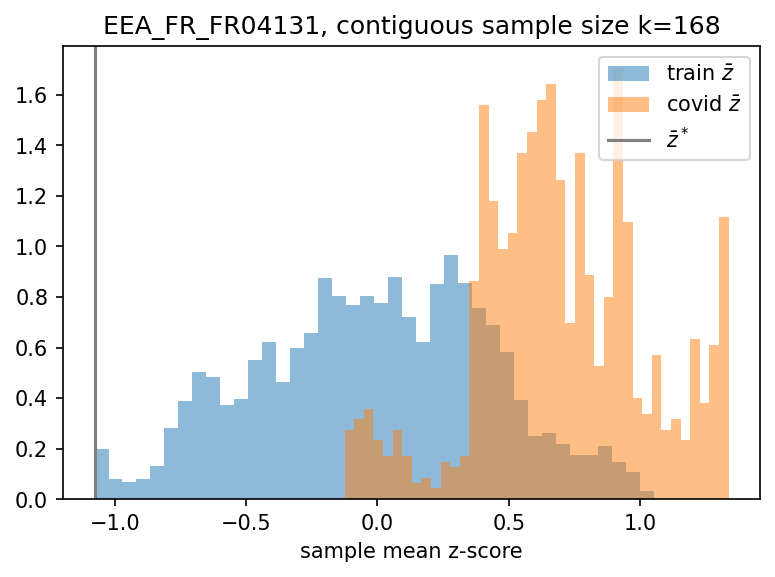

In [21]:
plt.figure(dpi=150)
plt.hist(train_k_averages, bins=40, density=True, color="tab:blue", alpha=0.5, label="train $\\bar z$")
# plt.hist(control_k_averages, bins=40, density=True, color="tab:orange", alpha=0.5, label="hindcast $\\bar z$")
plt.hist(covid_k_averages, bins=40, density=True, color="tab:orange", alpha=0.5, label="covid $\\bar z$")
plt.axvline(critical_z_bar, color="gray", label="$\\bar z^*$")
plt.title(f"{station_name}, contiguous sample size k={k}")
plt.xlabel("sample mean z-score")
l = np.linspace(min(train_k_averages), max(train_k_averages))
# if consecutive z-scores were iid, we would expect this distribution to have std = 1/sqrt(k)
# plt.plot(l, norm.pdf(l, loc=0, scale=1/np.sqrt(k)), label="sample mean of iid z-scores")
plt.legend()

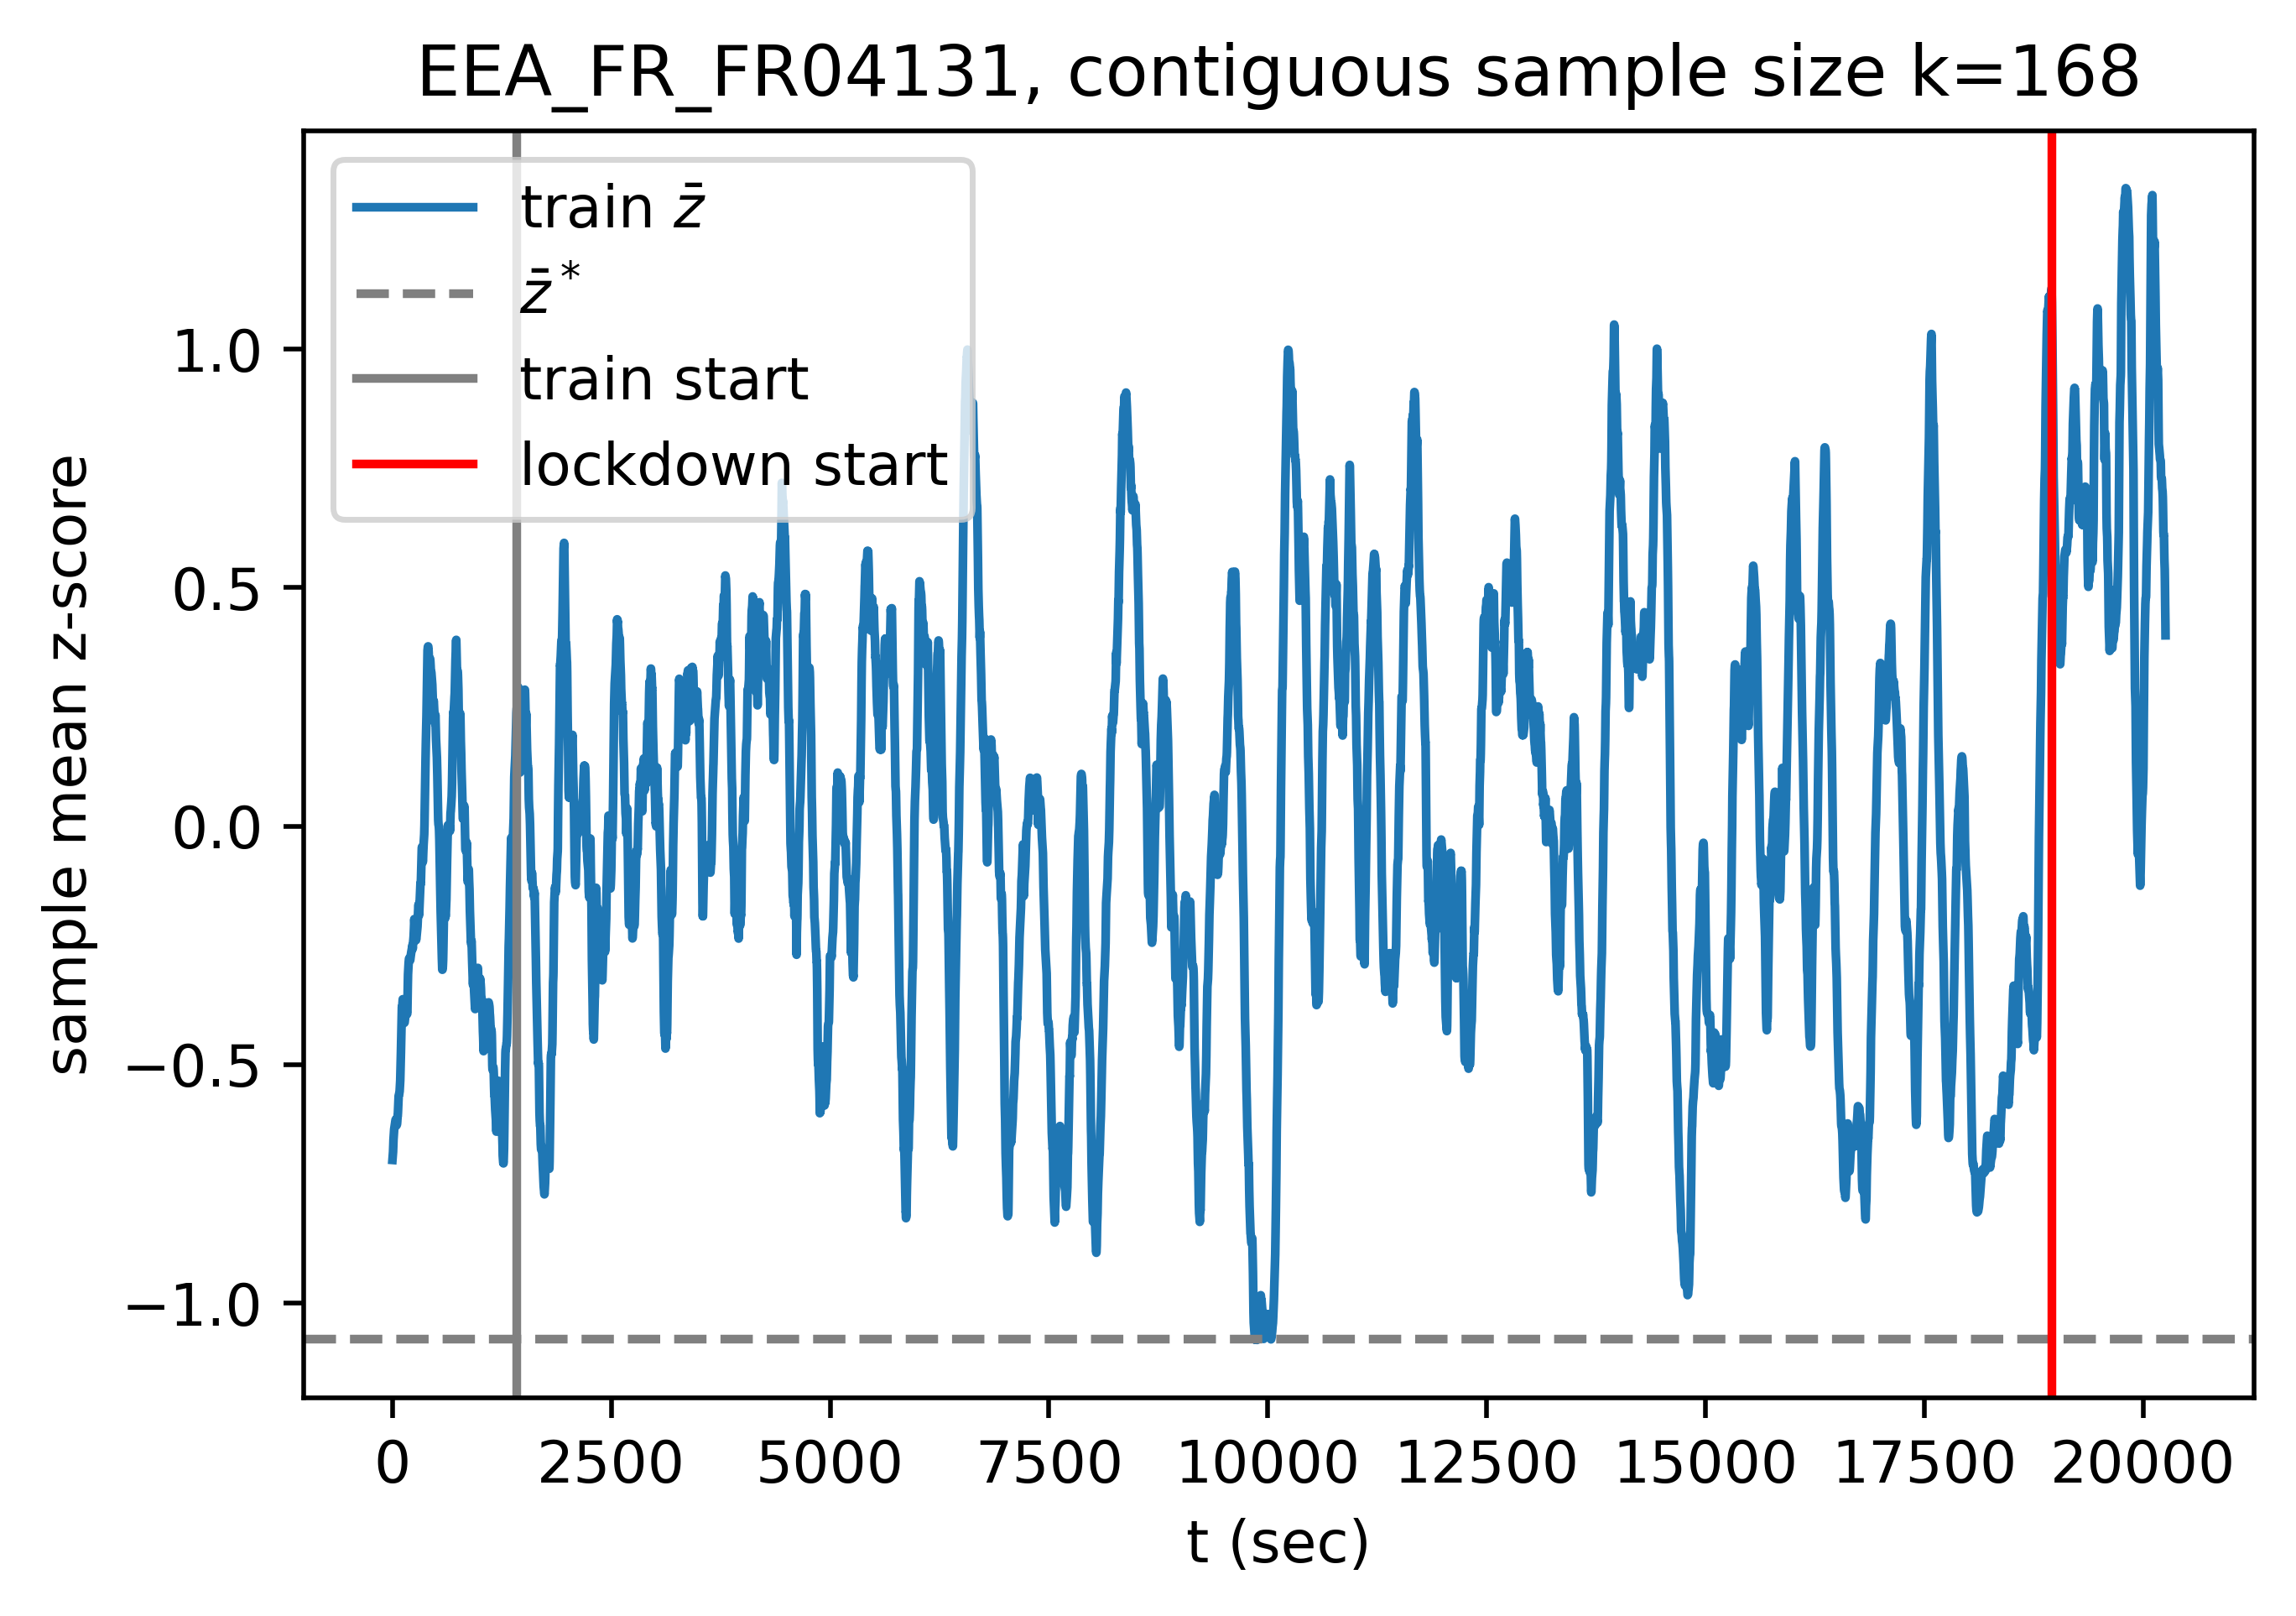

In [27]:
plt.figure(dpi=500)
plt.plot(k_averages, color="tab:blue", label="train $\\bar z$")
plt.axhline(critical_z_bar, color="gray", linestyle="--", label="$\\bar z^*$")
plt.axvline(train_start, color="gray", label="train start")
plt.axvline(train_end, color="red", label="lockdown start")
plt.title(f"{station_name}, contiguous sample size k={k}")
plt.xlabel("t (sec)")
plt.ylabel("sample mean z-score")
plt.legend()

In [22]:
alpha = 0.001
train_k_mses = k_mses[train_start:train_end - k + 1]
covid_k_mses = k_mses[train_end:]
control_k_mses = k_mses[:train_start - k + 1]
critical_mse_z = sorted(control_k_mses)[-int(len(control_k_mses) * alpha)]

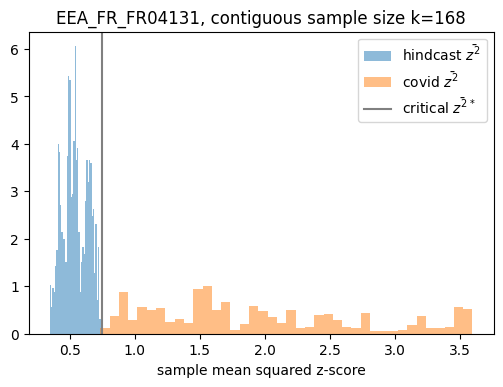

In [23]:
plt.figure(dpi=100)
# plt.hist(train_k_mses, bins=40, density=True, color="tab:blue", alpha=0.5, label="train $\\bar{z^2}$")
plt.hist(control_k_mses, bins=40, density=True, color="tab:blue", alpha=0.5, label="hindcast $\\bar{z^2}$")
plt.hist(covid_k_mses, bins=40, density=True, color="tab:orange", alpha=0.5, label="covid $\\bar{z^2}$")
plt.axvline(critical_mse_z, color="gray", label="critical $\\bar{z^2}^*$")
plt.title(f"{station_name}, contiguous sample size k={k}")
plt.xlabel("sample mean squared z-score")
plt.legend()

In [33]:
t2 = 5 * (t - max(t) / 2)
params2 = koop.predict(t2, covariates=t2.reshape(len(t), 1))
mu_hat2, sigma_hat2 = params2
mean_hat2 = model.mean(params2)
std_hat2 = model.std(params2)

Text(0.5, 1.0, 'EEA_FR_FR04131')

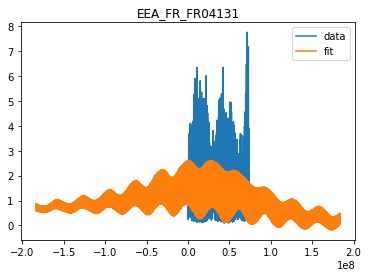

In [34]:
plt.plot(t, x, label="data")
plt.plot(t2, mean_hat2, label="fit")
plt.legend()
plt.title(station_name)

## put z-scores into a dataframe labeled by timestamp, so that we can compare between obs and model

In [35]:
len(z_scores), len(t)

(20424, 20424)

In [36]:
if station_fname.startswith("obs"):
    timestamps = obs_no2.loc[((tt in t) for tt in obs_no2.t)].ISO8601
else:
    timestamps = mod.loc[((tt in t) for tt in mod.t)].ISO8601
timestamps

360     2018-01-16 00:00:00
361     2018-01-16 01:00:00
362     2018-01-16 02:00:00
363     2018-01-16 03:00:00
364     2018-01-16 04:00:00
                ...        
20779   2020-05-15 19:00:00
20780   2020-05-15 20:00:00
20781   2020-05-15 21:00:00
20782   2020-05-15 22:00:00
20783   2020-05-15 23:00:00
Name: ISO8601, Length: 20424, dtype: datetime64[ns]

In [37]:
z_df = pd.DataFrame({"ISO8601": timestamps, "t": t, "z_score": z_scores.flatten()})
z_df.t += (t_min - 1514793600)  # align t but don't use epoch time
z_df

,ISO8601,t,z_score
360,2018-01-16 00:00:00,1296000.0,-1.060966
361,2018-01-16 01:00:00,1299600.0,-1.111271
362,2018-01-16 02:00:00,1303200.0,-1.167776
363,2018-01-16 03:00:00,1306800.0,-1.222201
364,2018-01-16 04:00:00,1310400.0,-1.259773
...,...,...,...
20779,2020-05-15 19:00:00,74800800.0,3.006212
20780,2020-05-15 20:00:00,74804400.0,2.627108
20781,2020-05-15 21:00:00,74808000.0,1.877281
20782,2020-05-15 22:00:00,74811600.0,1.531452


In [38]:
if station_fname.startswith("obs"):
    param_str = f"NormalNLL_{station_fname[:-4]}_{l1width}_{l2width}_{batch_size}_{total_iters}_{seed}_{wd}_{lrt}"
    pd_name = f"obs_z_{param_str}.pkl"
    pd.to_pickle(z_df, pd_name)
pd_name

NameError: name 'pd_name' is not defined

# load z-scores for obs, so that we can compare them against model

In [39]:
pd_name = 'obs_z_NormalNLL_obs_EEA_FR_FR04131_256_1024_32_1_633_0.001_0.0001.pkl'
obs_z_df = pd.read_pickle(pd_name)

In [40]:
obs_z_df.ISO8601.min(), z_df.ISO8601.min()

(Timestamp('2018-01-16 00:00:00'), Timestamp('2018-01-16 00:00:00'))

In [41]:
from scipy import interpolate
mod_t = z_df.t.values
mod_z = z_df.z_score.values
f = interpolate.interp1d(mod_t, mod_z)
obs_t = obs_z_df.t.values
obs_z = obs_z_df.z_score.values
aligned_mod_z = f(obs_t)

In [42]:
zdiff = obs_z - aligned_mod_z

In [43]:
train_start_date = np.datetime64("2018-03-16")
train_end_date = np.datetime64("2020-03-16")
covid_end_date = np.datetime64("2020-05-16")
aligned_train_start = np.argwhere(obs_z_df.ISO8601.values >= train_start_date)[0, 0]
aligned_train_end = np.argwhere(obs_z_df.ISO8601.values <= train_end_date)[-1, 0]
aligned_covid_end = np.argwhere(obs_z_df.ISO8601.values <= covid_end_date)[-1, 0]

Text(0, 0.5, '$z_{obs} - z_{mod}$')

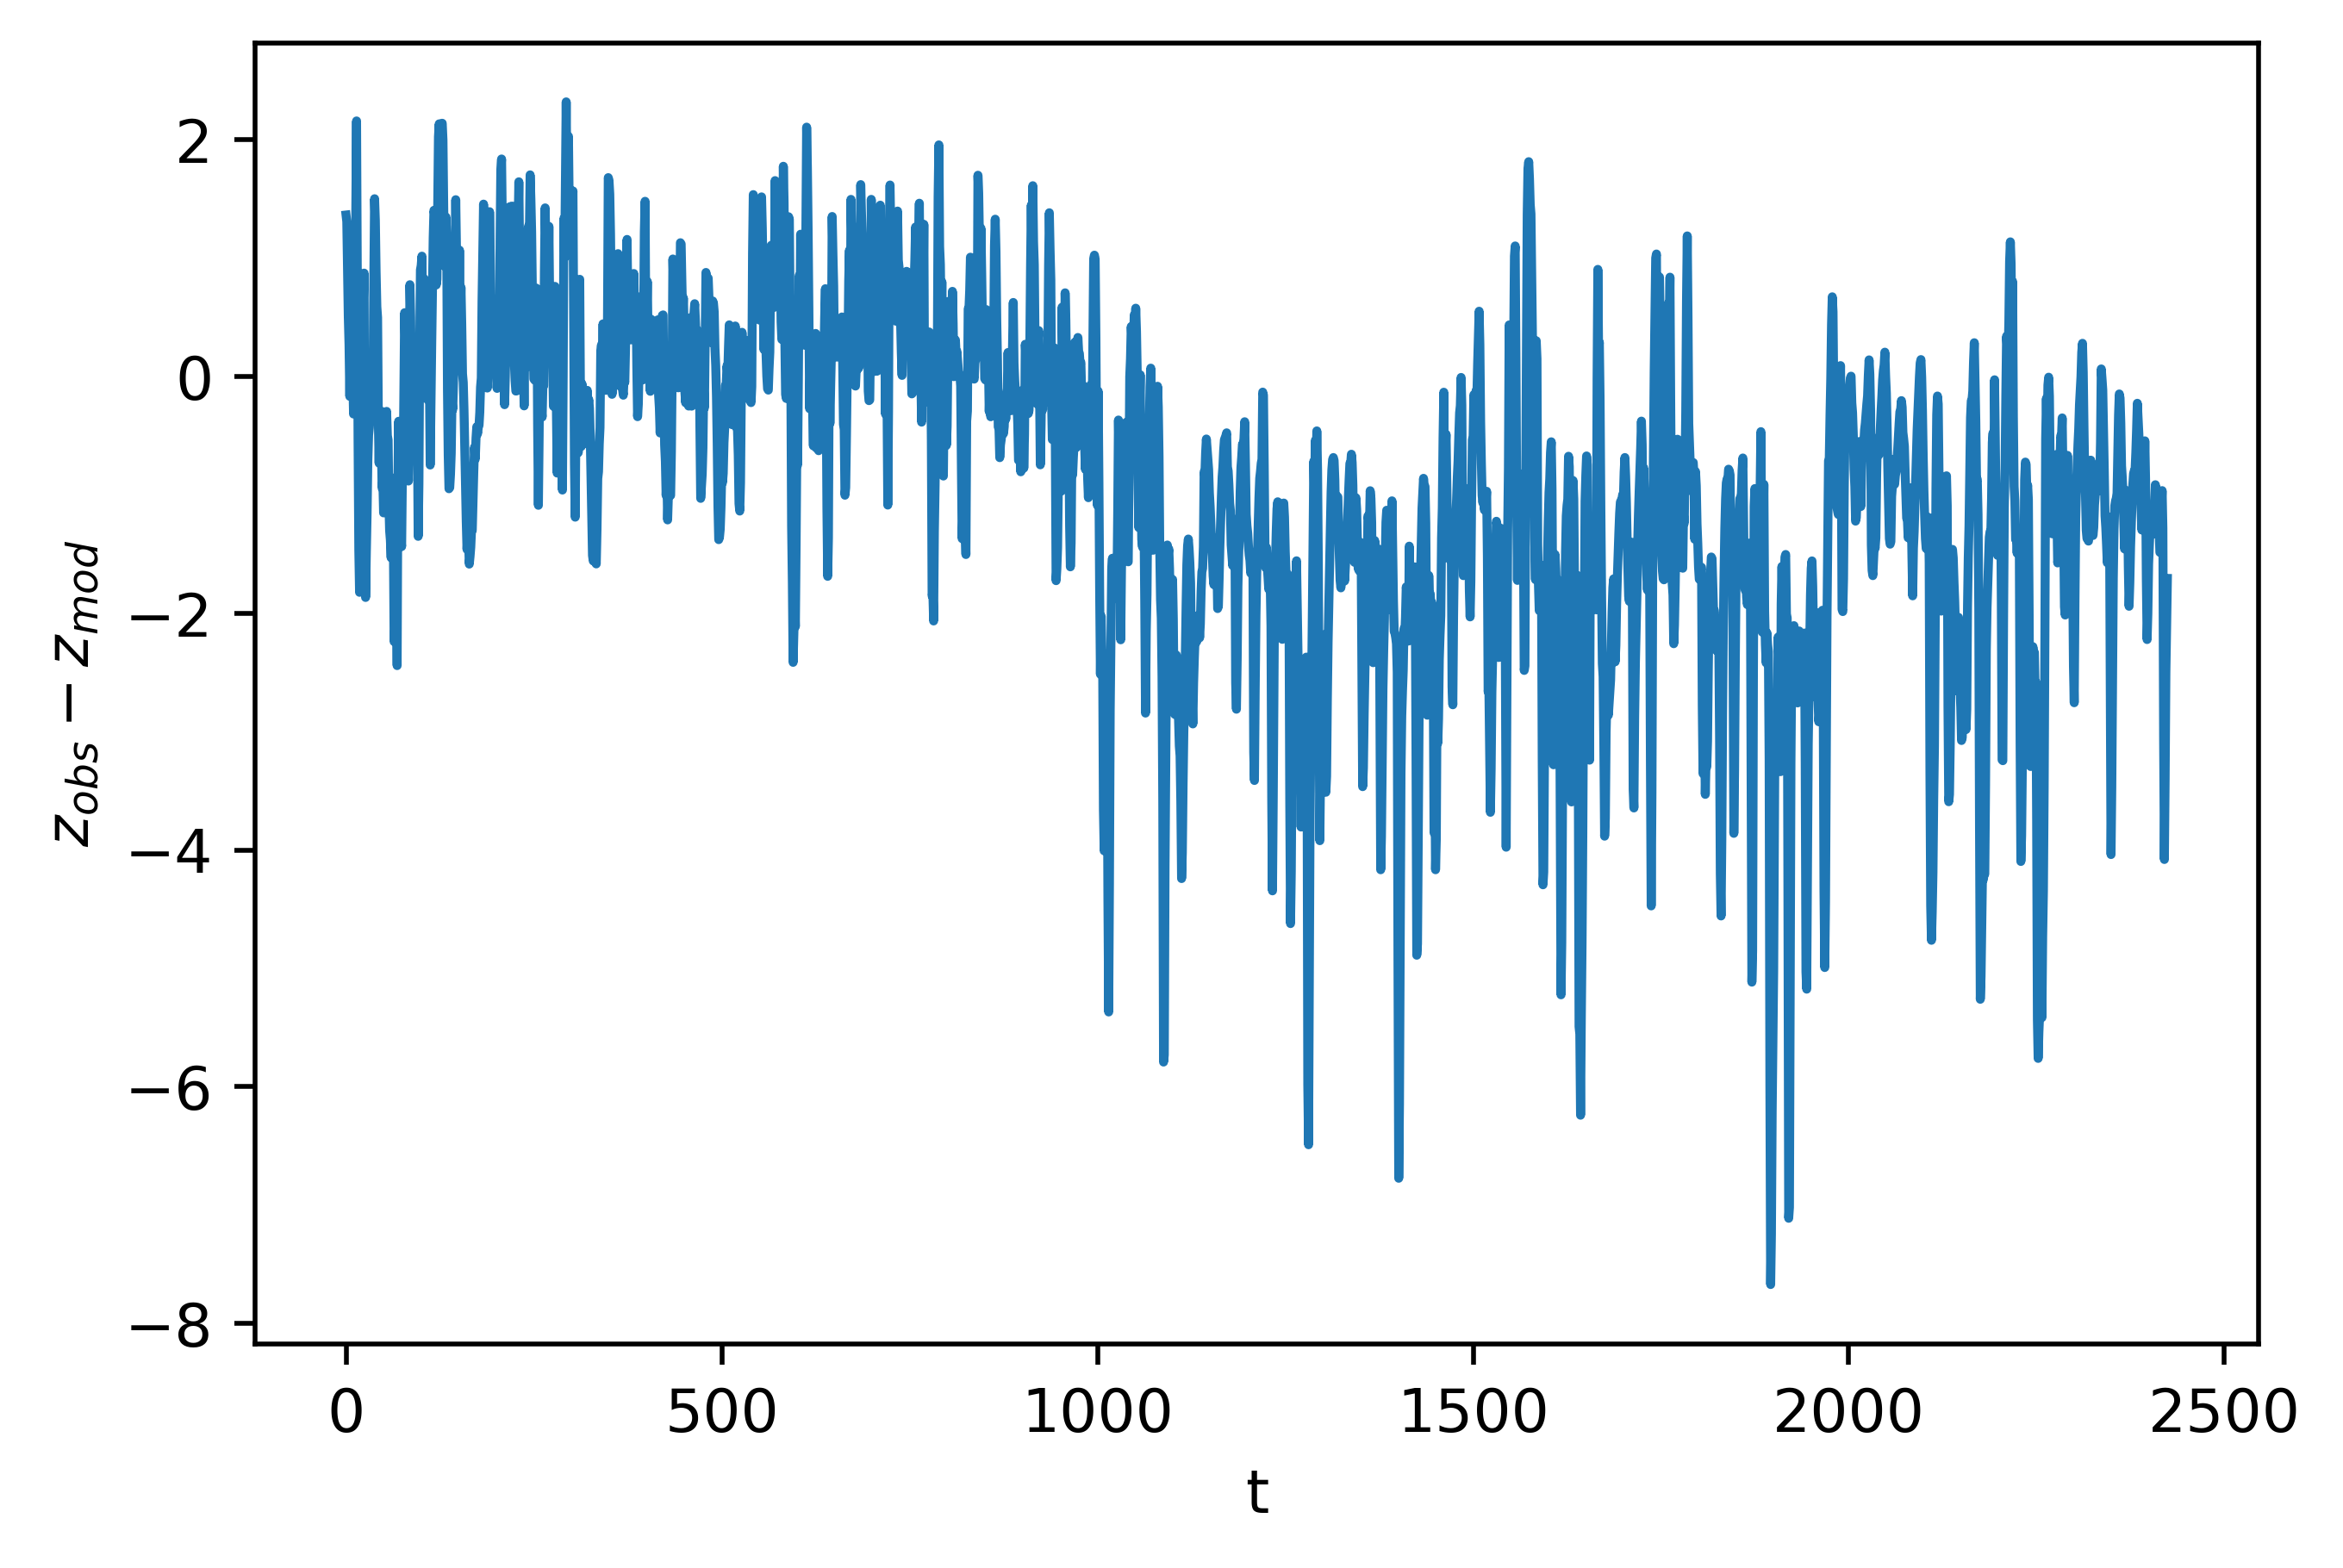

In [44]:
plt.figure(dpi=500)
plt.plot(zdiff[aligned_train_end - 1000:covid_end])
plt.xlabel("t")
plt.ylabel("$z_{obs} - z_{mod}$")

In [45]:
# find the sampling distribution of consecutive k-averages (k_average = average z-score of k consecutive observations)
k = 24 * 7
k_averages = []
k_mses = []
k_samples = np.zeros((aligned_covid_end - k + 1, k))

for i in range(0, aligned_covid_end - k + 1):
    sample = zdiff[i:i+k]
    k_averages.append(np.mean(sample))
    k_mses.append(np.mean(sample**2))
    k_samples[i, :] = sample.flatten()

train_zdiff = zdiff[aligned_train_start:aligned_train_end - k + 1]

alpha = 0.001
train_k_averages = k_averages[aligned_train_start:aligned_train_end - k + 1]
covid_k_averages = k_averages[aligned_train_end:]
control_k_averages = k_averages[:aligned_train_start - k + 1]
critical_z_bar = sorted(train_k_averages)[int(len(train_k_averages) * alpha)]

alpha = 0.001
train_k_averages = k_averages[aligned_train_start:aligned_train_end - k + 1]
covid_k_averages = k_averages[aligned_train_end:]
control_k_averages = k_averages[:aligned_train_start - k + 1]
critical_z_bar = sorted(train_k_averages)[int(len(train_k_averages) * alpha)]

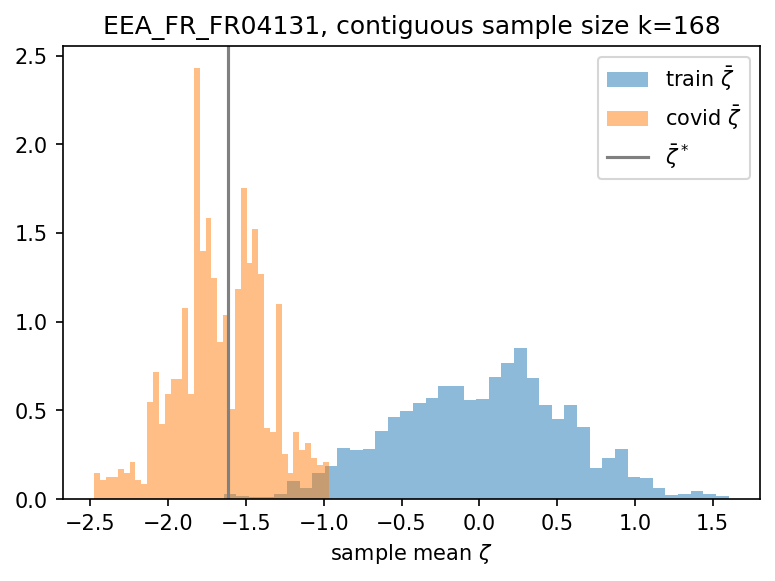

In [46]:
plt.figure(dpi=150)
plt.hist(train_k_averages, bins=40, density=True, color="tab:blue", alpha=0.5, label="train $\\bar \zeta$")
# plt.hist(control_k_averages, bins=40, density=True, color="tab:orange", alpha=0.5, label="hindcast $\\bar z$")
plt.hist(covid_k_averages, bins=40, density=True, color="tab:orange", alpha=0.5, label="covid $\\bar \zeta$")
plt.axvline(critical_z_bar, color="gray", label="$\\bar \zeta^*$")
plt.title(f"{station_name}, contiguous sample size k={k}")
plt.xlabel("sample mean $\zeta$")
l = np.linspace(min(train_k_averages), max(train_k_averages))
# if consecutive z-scores were iid, we would expect this distribution to have std = 1/sqrt(k)
# plt.plot(l, norm.pdf(l, loc=0, scale=1/np.sqrt(k)), label="sample mean of iid z-scores")
plt.legend()

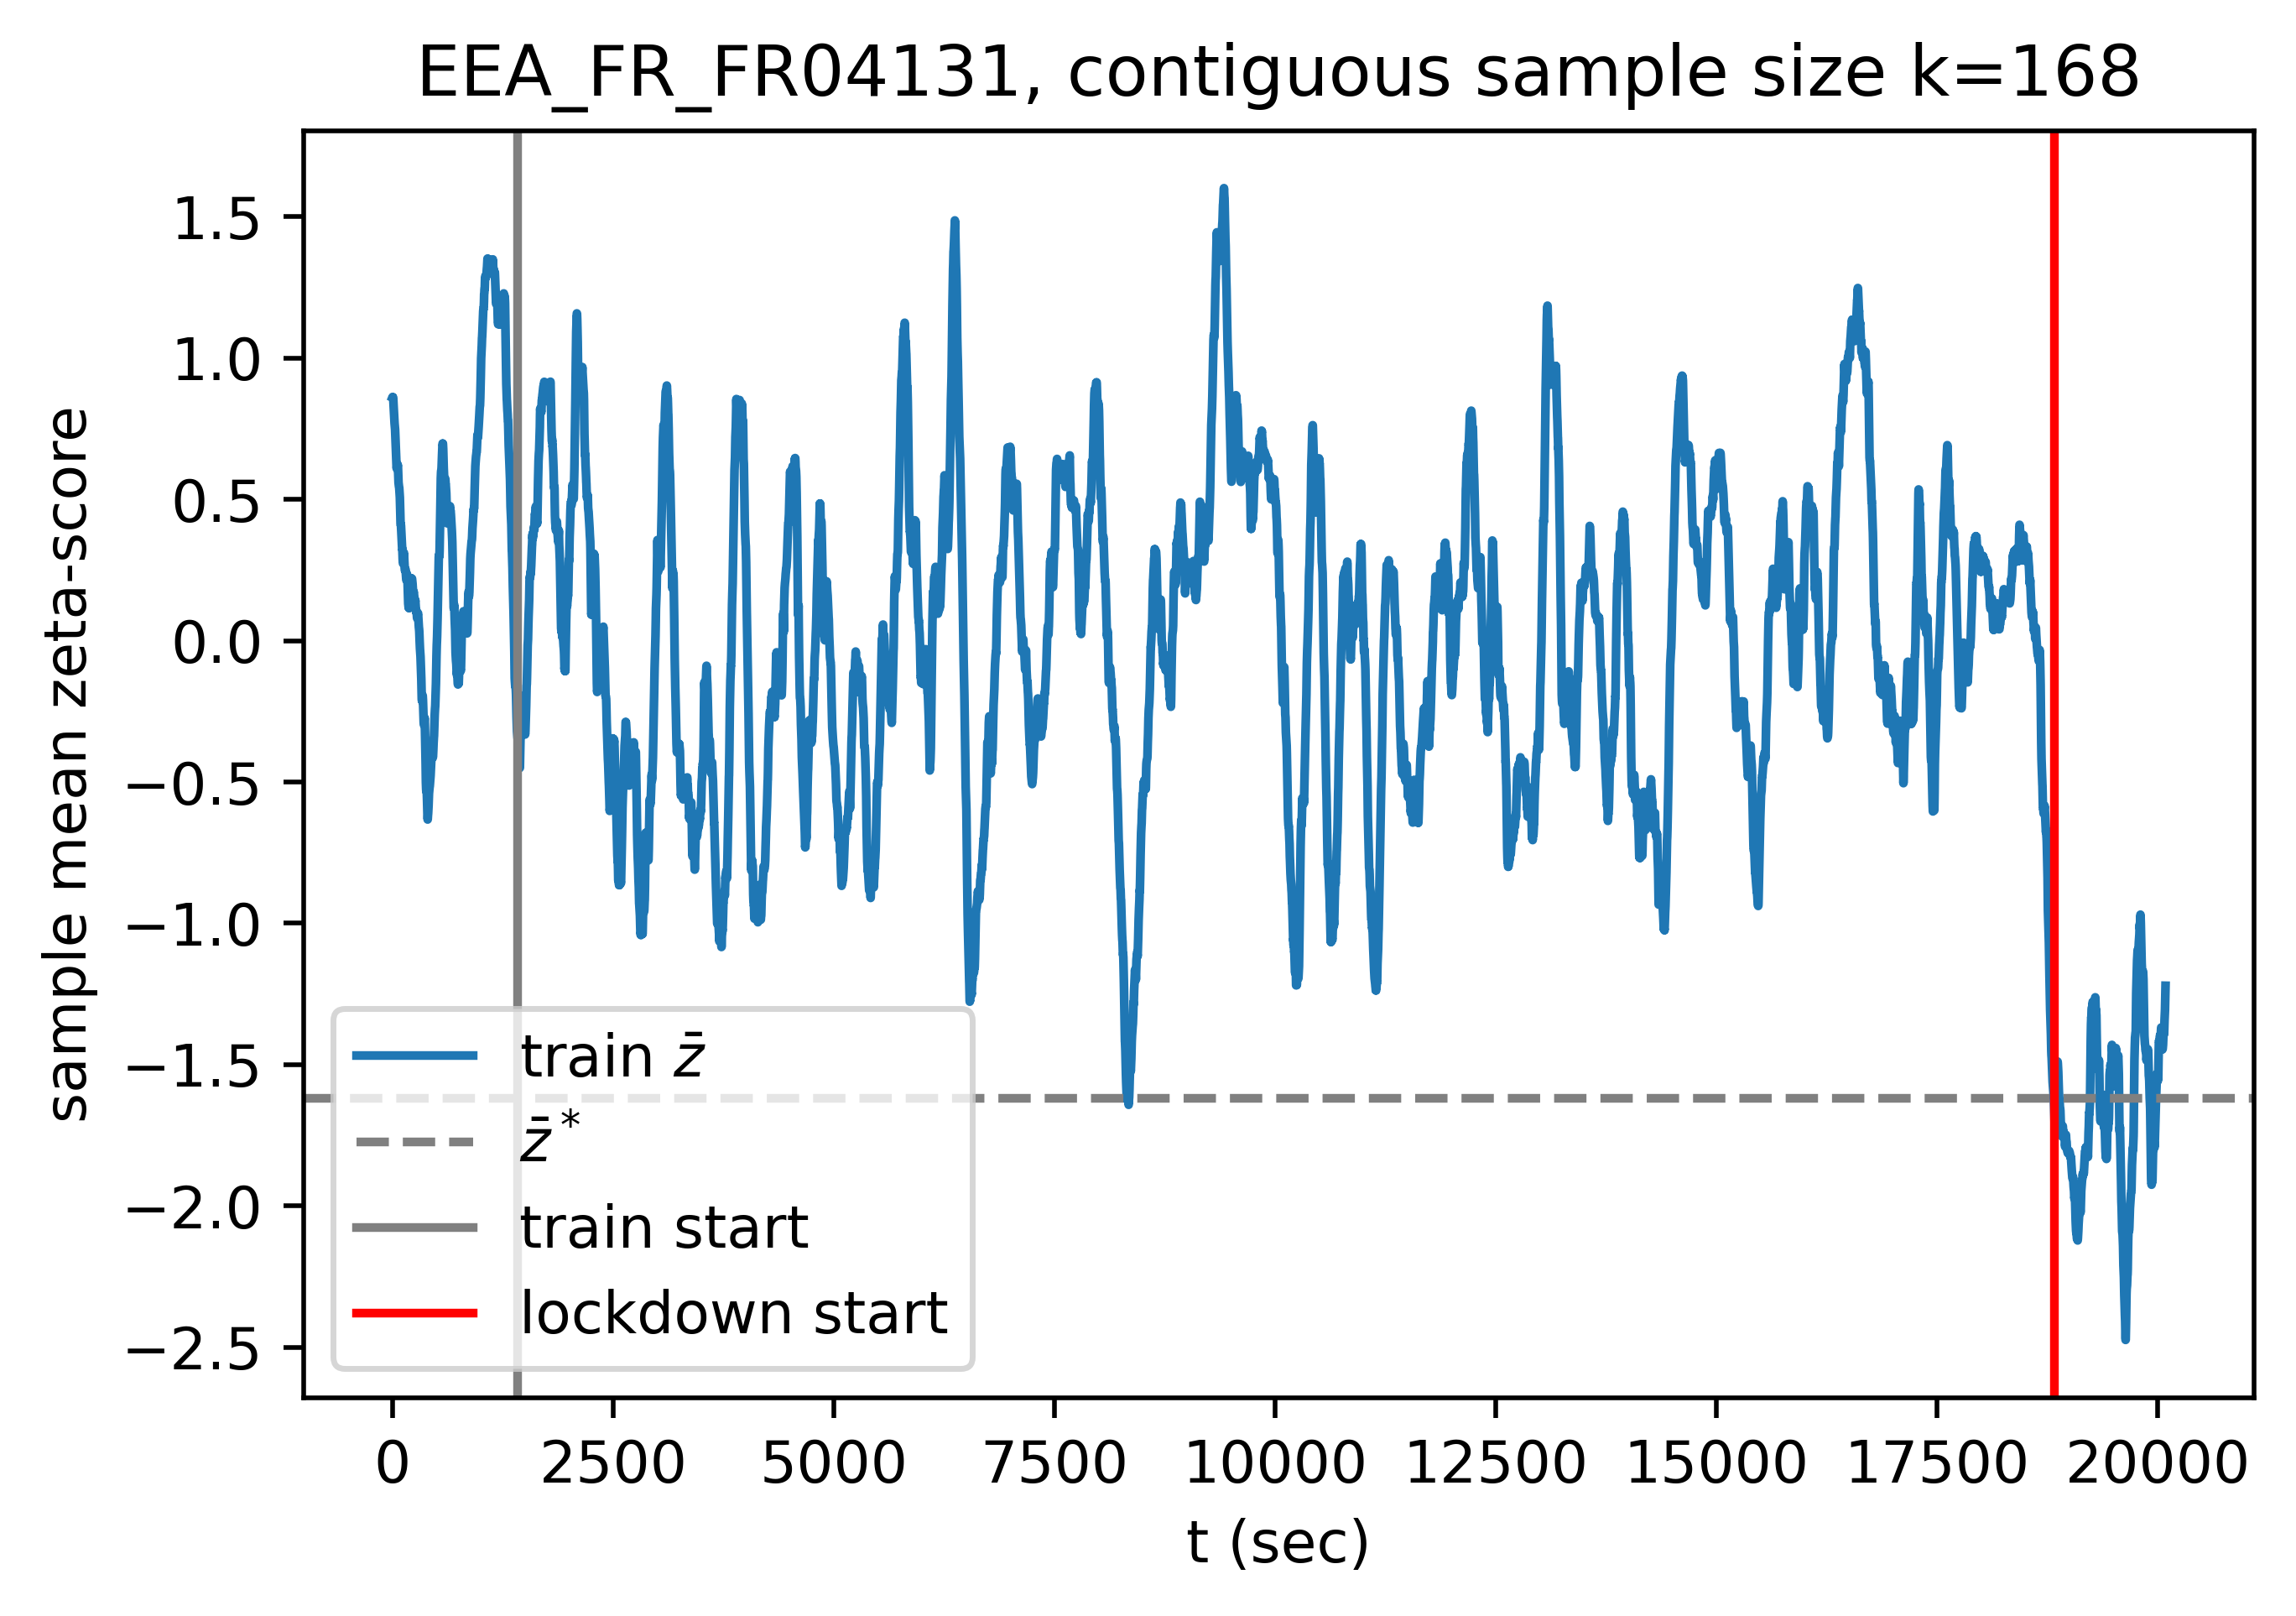

In [53]:
plt.figure(dpi=500)
plt.plot(k_averages, color="tab:blue", label="train $\\bar z$")
plt.axhline(critical_z_bar, color="gray", linestyle="--", label="$\\bar z^*$")
plt.axvline(aligned_train_start, color="gray", label="train start")
plt.axvline(aligned_train_end, color="red", label="lockdown start")
plt.title(f"{station_name}, contiguous sample size k={k}")
plt.xlabel("t (sec)")
plt.ylabel("sample mean zeta-score")
plt.legend()

In [49]:
alpha = 0.001
train_k_mses = k_mses[train_start:train_end - k + 1]
covid_k_mses = k_mses[train_end:]
control_k_mses = k_mses[:train_start - k + 1]
critical_mse_z = sorted(control_k_mses)[-int(len(control_k_mses) * alpha)]

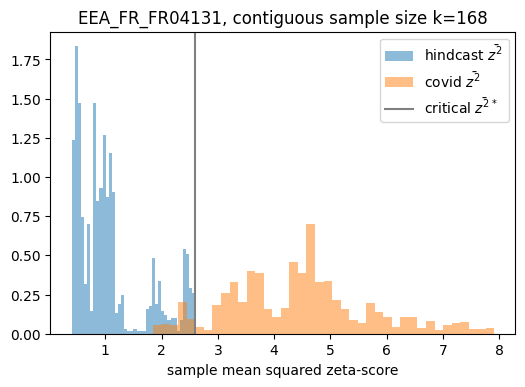

In [51]:
plt.figure(dpi=100)
# plt.hist(train_k_mses, bins=40, density=True, color="tab:blue", alpha=0.5, label="train $\\bar{z^2}$")
plt.hist(control_k_mses, bins=40, density=True, color="tab:blue", alpha=0.5, label="hindcast $\\bar{z^2}$")
plt.hist(covid_k_mses, bins=40, density=True, color="tab:orange", alpha=0.5, label="covid $\\bar{z^2}$")
plt.axvline(critical_mse_z, color="gray", label="critical $\\bar{z^2}^*$")
plt.title(f"{station_name}, contiguous sample size k={k}")
plt.xlabel("sample mean squared zeta-score")
plt.legend()

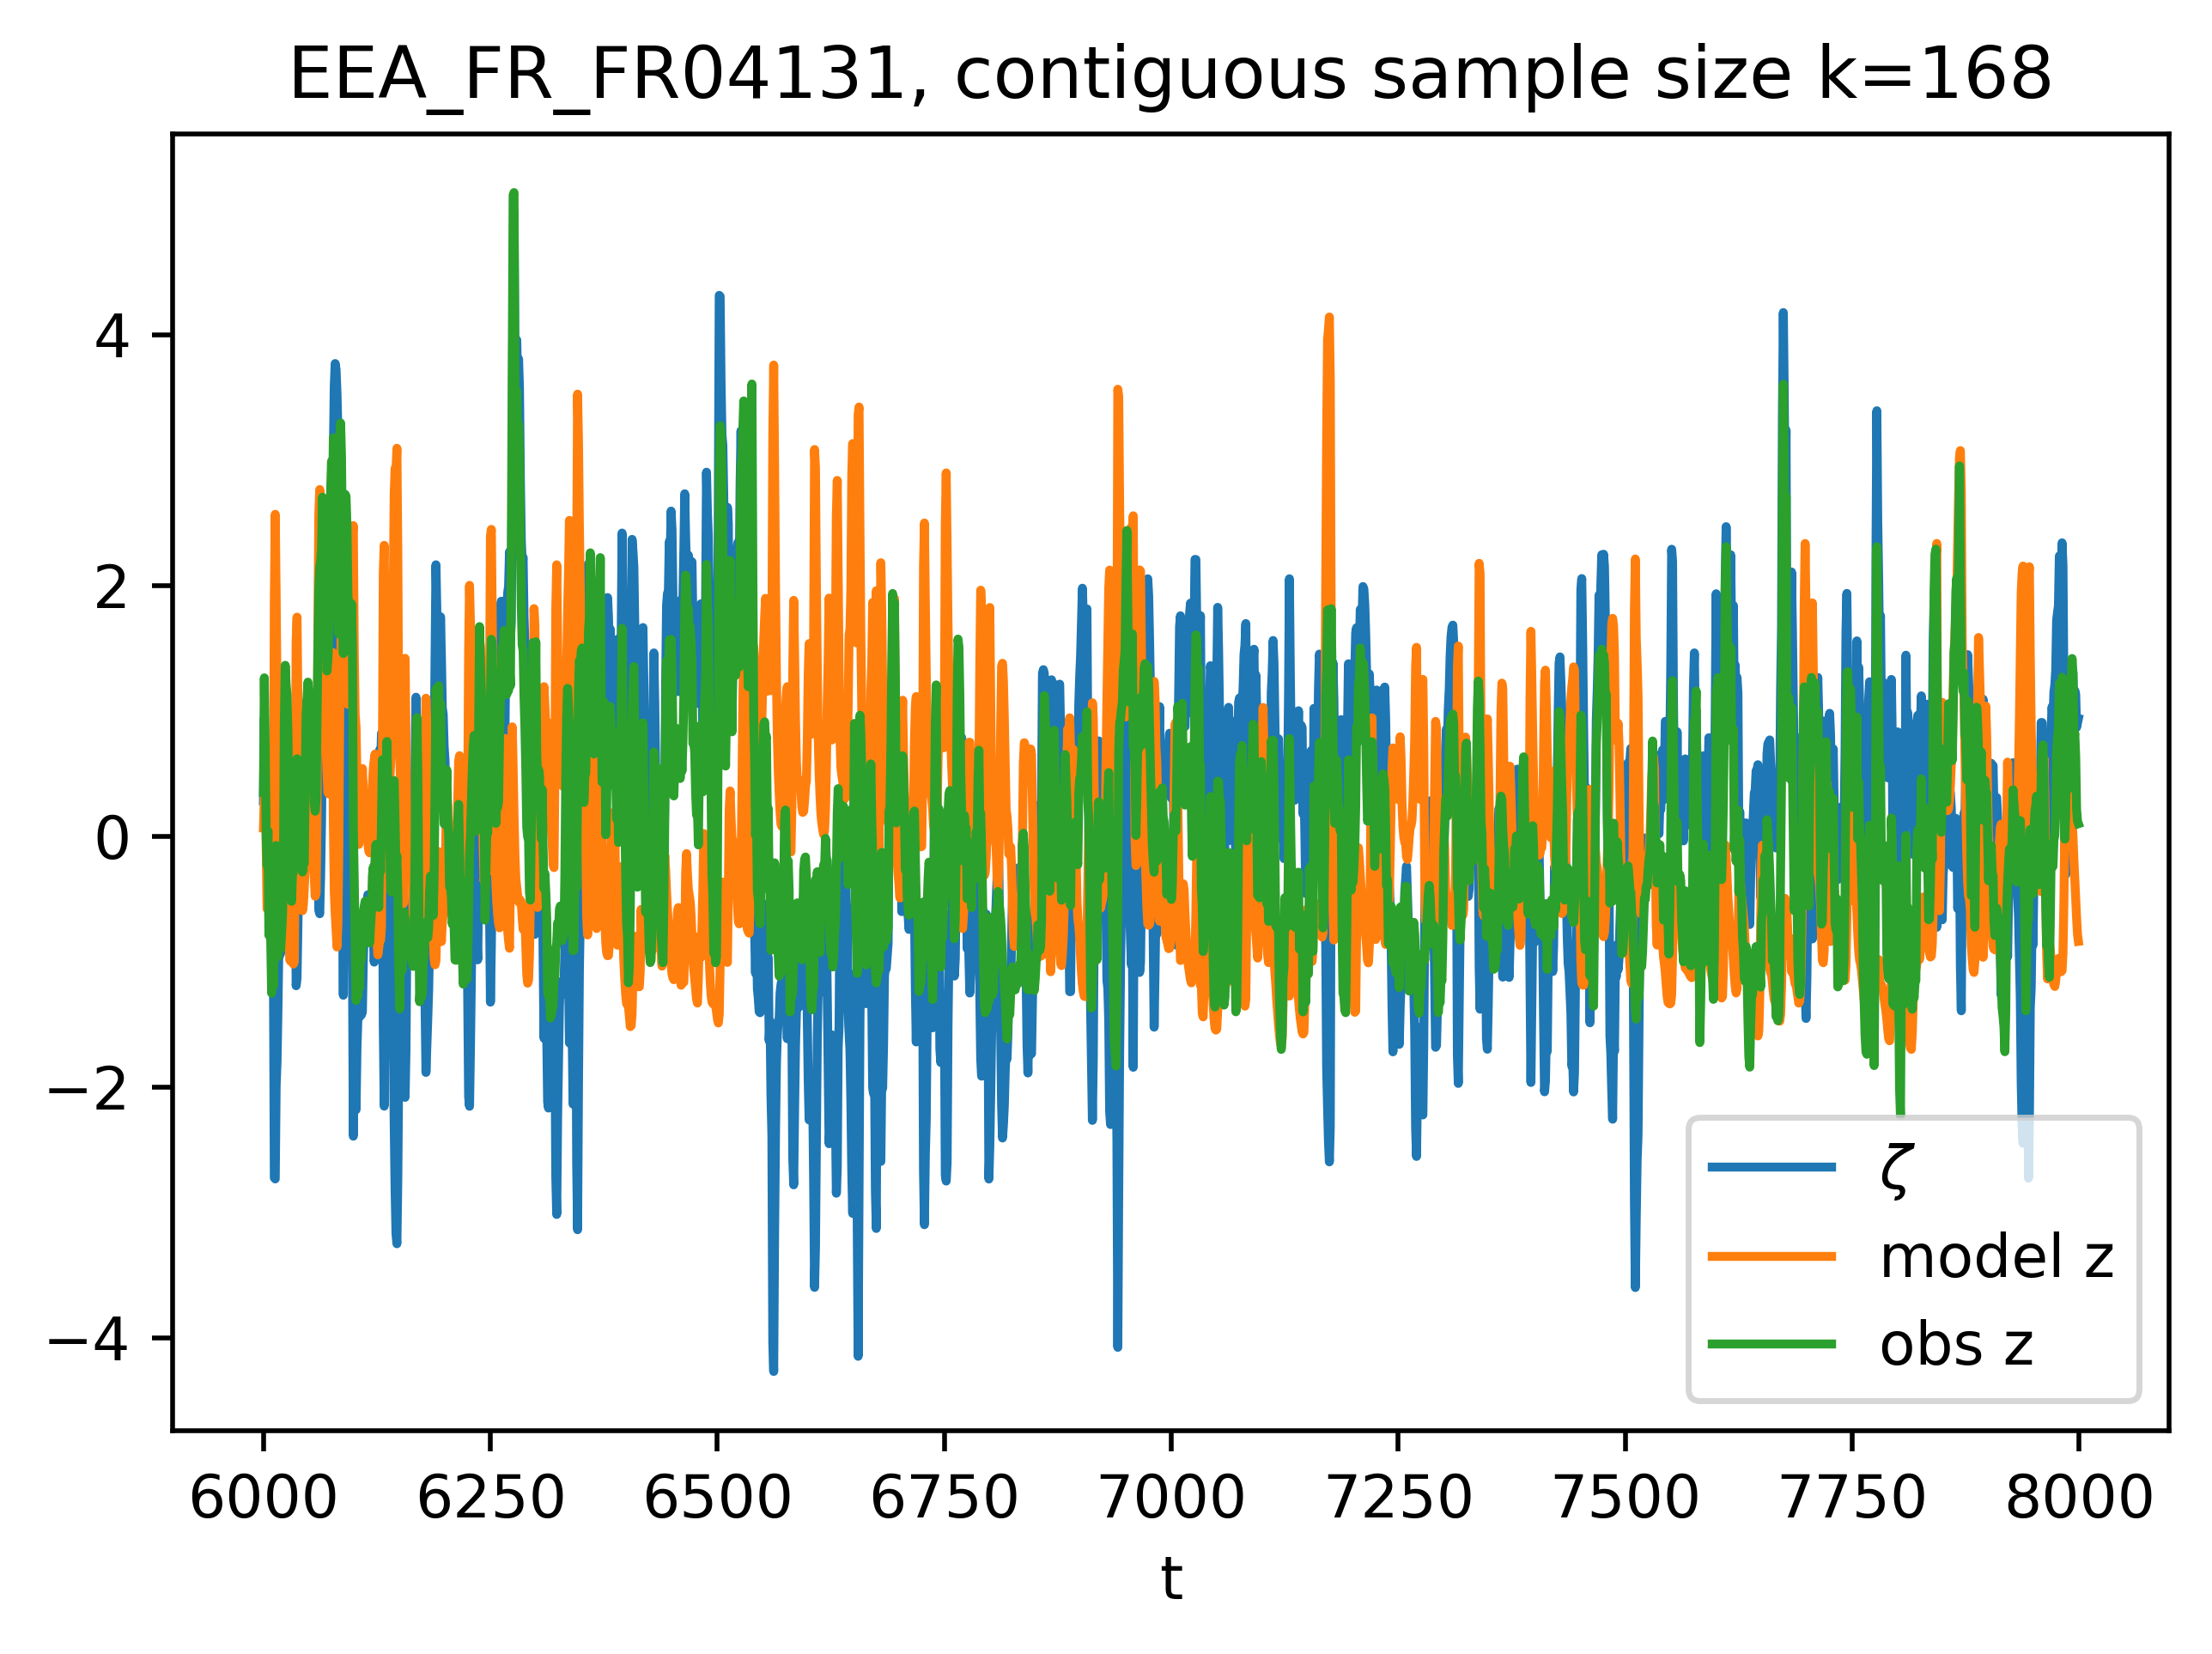

In [52]:
plt.figure(dpi=500)
plt.title(f"{station_name}, contiguous sample size k={k}")
plt.plot(np.arange(6000, 8000), zdiff[6000:8000], label="$\zeta$")
plt.plot(np.arange(6000, 8000), aligned_mod_z[6000:8000], label="model z")
plt.plot(np.arange(6000, 8000), obs_z[6000:8000], label="obs z")
plt.xlabel("t")
# plt.ylabel("$z_{obs} - z_{mod}$")
plt.legend()